# Apriori Algorithm for Association Rules

This notebook demonstrates how to use the Apriori algorithm to find association rules.

## Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules

## Define helper functions

In [2]:
def render_mpl_table(
        data: pd.DataFrame, col_width: float = 4.0, row_height: float = 0.625,
        font_size: int = 10, header_color: str = "#179E86",
        row_colors: list = ["#f1f1f2", "#ffffff"], edge_color: str = "black",
        bbox: list = [0, 0, 1, 1], header_font_color: str = "white",
        ax: plt.Axes = None, **kwargs) -> plt.Axes:
    """Function to display the DataFrame as a table with colored cells.

    Args:
        data (pd.DataFrame): The DataFrame to be displayed as a table.
        col_width (float, optional): The width of the columns. Defaults to 4.0.
        row_height (float, optional): The height of the rows. Defaults to 0.625.
        font_size (int, optional): The font size. Defaults to 14.
        header_color (str, optional): The color of the header. Defaults to
            "#179E86".
        row_colors (list, optional): The colors of the rows. Defaults to
            ["#f1f1f2", "#ffffff"].
        edge_color (str, optional): The color of the edges. Defaults to "black".
        bbox (list, optional): The bounding box. Defaults to [0, 0, 1, 1].
        header_font_color (str, optional): The color of the header font.
            Defaults to "white".
        ax (plt.Axes, optional): The axes to be used. Defaults to None.

    Returns:
        plt.Axes: The axes with the table.
    """

    # Create the figure and axes if not provided.
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * \
            np.array([col_width, row_height])
        _, ax = plt.subplots(figsize=size)
        ax.axis("off")

    # Create the table.
    mpl_table = ax.table(
        cellText=[
            [
                str(cell)
                    .replace("frozenset({", "")
                    .replace("})", "") for cell in row
            ] for row in data.values
        ],
        bbox=bbox,
        colLabels=data.columns,
        colWidths=[0.30, 0.70],
        **kwargs
    )

    # Set the font size.
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    # Styling the table.
    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)

        # Header row.
        if k[0] == 0:
            cell.set_text_props(weight="bold", color=header_font_color)
            cell.set_facecolor(header_color)

        # Alternate row coloring
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    return ax


def encode_units(x: int) -> int:
    """
    Function to encode units.

    Args:
        x (int): The quantity of the product.

    Returns:
        int: 1 if the quantity is greater than 0, 0 otherwise.
    """
    return 1 if x > 0 else 0

## Load and prepare data

In [3]:
# Read the Excel file.
df = pd.read_excel("./data/online_retail.xlsx")

# Perform data cleaning to remove the rules that do not have invoice number.
df["Description"] = df["Description"].str.strip()
df["InvoiceNo"] = df["InvoiceNo"].astype("str")
df = df[~df["InvoiceNo"].str.contains("C")]

## Create shopping cart

In [4]:
# Create a shopping cart.
shopping_cart = df[df["Country"] == "Portugal"].groupby(
    ["InvoiceNo", "Description"]
)["Quantity"].sum().unstack().reset_index().fillna(0).set_index("InvoiceNo")

# Apply the encoding function to the shopping cart.
shopping_cart_sets = shopping_cart.map(encode_units)

# Drop the "POSTAGE" column if it exists.
if "POSTAGE" in shopping_cart_sets.columns:
    shopping_cart_sets.drop("POSTAGE", inplace=True, axis=1)

## Apply Apriori algorithm

In [5]:
# Apply the apriori algorithm with a minimum support of 0.07.
frequent_itemsets = apriori(
    shopping_cart_sets, min_support=0.07, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False)

/Users/fabricio/.miniforge3/envs/damin2025/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


## Visualize frequent itemsets

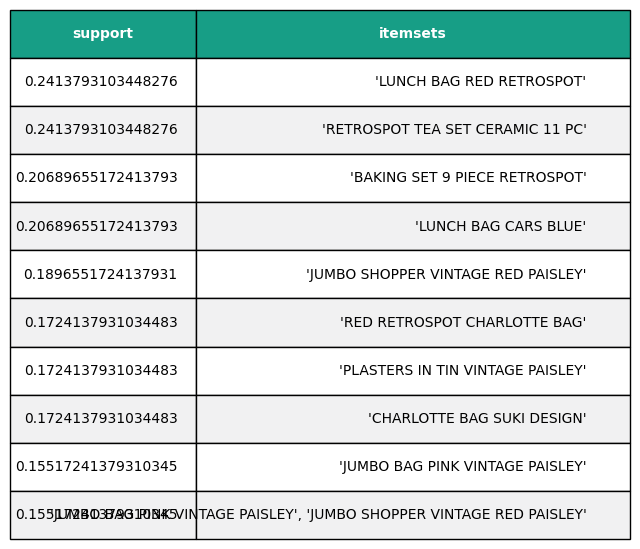

In [6]:
# Render the table.
render_mpl_table(frequent_itemsets.head(10))
plt.show()

## Generate association rules

In [7]:
# Generate the association rules.
rules = association_rules(
    frequent_itemsets, num_itemsets=len(frequent_itemsets),
    metric="lift", min_threshold=1
)

# Select the rules with a lift greater than 6 and a confidence greater than 0.8.
selected_rules = rules[(rules["lift"] >= 6) & (rules["confidence"] >= 0.8)]
print(
    selected_rules.head(30)[
        ["antecedents", "consequents", "support", "confidence", "lift"]
    ]
)

                                           antecedents  \
8    (JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...   
9                     (JUMBO BAG PINK VINTAGE PAISLEY)   
16   (LUNCH BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...   
17                    (JUMBO BAG PINK VINTAGE PAISLEY)   
32   (JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...   
38                   (SCANDINAVIAN PAISLEY PICNIC BAG)   
39                   (PINK VINTAGE PAISLEY PICNIC BAG)   
60   (LUNCH BAG RED RETROSPOT, JUMBO BAG SCANDINAVI...   
73   (LUNCH BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...   
74   (JUMBO BAG PINK VINTAGE PAISLEY, LUNCH BAG RED...   
76   (JUMBO BAG PINK VINTAGE PAISLEY, JUMBO BAG SCA...   
77   (LUNCH BAG RED RETROSPOT, JUMBO SHOPPER VINTAG...   
78   (LUNCH BAG RED RETROSPOT, JUMBO BAG SCANDINAVI...   
79   (JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ...   
90   (PLASTERS IN TIN SPACEBOY, PLASTERS IN TIN VIN...   
92   (PLASTERS IN TIN VINTAGE PAISLEY, PLASTERS IN ...   
93            

## Visualize association rules

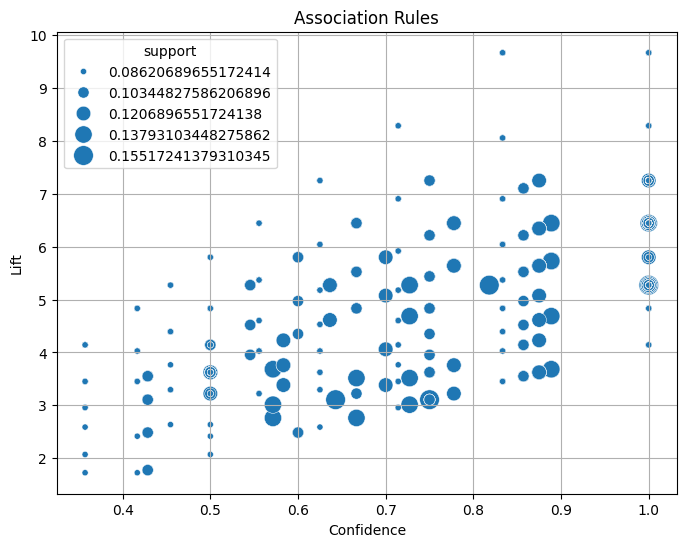

In [8]:
# Plot the lift of the selected rules.
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="confidence", y="lift", size="support", data=rules,
    legend=True, sizes=(20, 200)
)
plt.title("Association Rules")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.grid(True)
plt.show()